# Milestone Project 2: Skimlit 📄 🔥

The purpose of this notebook is to build amodel to make reading medical abstracts easier.

The paper we're replicating (the source of the datset) is here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture they used to achieve their best results is available here: https://arxiv.org/abs/1612.05251


In [1]:
# ## Confirm GPU Access (not)
# !nvidia-smi

## Get Data 

Since we will be replicating the paper above (PubMed 200k RCT), let's download the datset they use.

We can do so from the author's github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed20k dataset (with at sign)
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

: 

In [ ]:
# Start our experiments using the 20k datset with numbers replaced by "@" sign
data_dir = "./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

: 

In [4]:
# Check all the filenames in the target dir
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 './pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/.ipynb_checkpoints']

## Preprocess Data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, Visualize, Visualize

Now with that in mind, let's write a function to read in all of the lines of a target text file`

In [5]:
# Create function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns lines of text as a list
    
    Args:
        filename: [str] string containing target filepath
    
    Returns:
        A list of strings with one string per line from the target filename
    """
    with open(filename, "r") as f:
        return f.readlines()

In [6]:
# Let's read in training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```python
[{'line_number: 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
   'total_lines': 11},
   ...]
```

In [8]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, reads it's contences and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences the current abstract has,
    and sentences number the target line is.
    """

    input_lines = get_lines(filename) # Get all lines from filename
    abstract_lines = "" # Create an empty abstract
    abstract_samples = []

    # Loop thru each line in the target file
    for line in input_lines:
        if line.startswith("###"):  # Check to see if the line is an ID line
            abstract_id = line
            abstract_lines = ""  # Reset abstract string if the line is an Id line

        elif line.isspace():  # Check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines()  # Split abstract into separate lines

            # Iterate thru each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # Create an empty dict
                target_text_split = abstract_line.split("\t")  # Split target label from text
                line_data["target"] = target_text_split[0]  # get target label
                line_data["text"] = target_text_split[1].lower()  # get target text and lower it
                line_data["line_number"] = abstract_line_number  # What number line does the line appear in the abstract
                line_data["total_lines"] = len(abstract_line_split) - 1  # How many total lines are there in the target abstract
                abstract_samples.append(line_data)  # Add line data to abstract samples list

        else:  # If the above conditions are not fufilled, the line contains a labelled sentence
            abstract_lines += line

    return abstract_samples

In [9]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [10]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a dataframe to further visualize it?

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [12]:
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

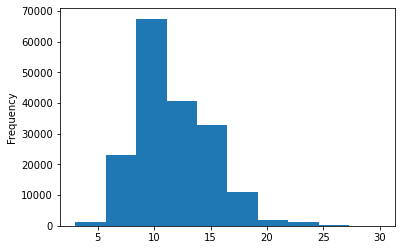

In [14]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [15]:
# COnvert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [16]:
# View the 1st 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML Models Require Numeric Labels)

In [17]:
# Check Sklearn Version
import sklearn
print(sklearn.__version__)

0.24.1


In [18]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # Non-Sparse Matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what One Hot Labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label Encode Labels

In [20]:
# Extract labels ("target column")
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy()) 
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Check what label encoded labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
# Get class names and num classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a Series of Modelling Experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best. 

And as alwyas, we're going to start with a baseline (TF-IDF MultinomialNB Classifier)

## Model 0: Getting a Baseline

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Create a pipeline
model_0 = Pipeline([('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate baseline model on validation dataset
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [23]:
# Make Predictions
baseline_preds = model_0.predict(val_sentences)

### Download helper functions script

In the previous module, we wrote a function to calculate different metrics for a set of predictions by am model. Let's Download it.

In [25]:
!curl -O https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10246  100 10246    0     0  60270      0 --:--:-- --:--:-- --:--:-- 60270


In [24]:
# Import script
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [26]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data (the text) for Deep Sequence Models

Before we start building deep models, we've got to create vectorization and embeddding layers

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [55]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

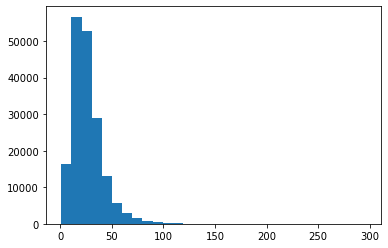

In [56]:
# What is the distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=30);

In [57]:
# How long of a sentence length covers 95% of examples
output_seq_length = int(np.percentile(sent_lens, 95))
output_seq_length

55

In [58]:
# Maximum seq length in training set
max(sent_lens)

296

### Creating a Text Vectorization Layer

In [59]:
# How many words are in our vocabulary?
max_tokens = 68000

In [60]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # Num words in vocab
                                    output_sequence_length=output_seq_length) # Number of vectorized tokens per sequence

In [34]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [35]:
# Test out the text vectorizer on random samples
import random

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of Text: {len(target_sentence.split())}")
print(f"\nVectorized text: \n {text_vectorizer([target_sentence])}")

Text:
economic evaluation is important for making decisions about resource allocation .

Length of Text: 11

Vectorized text: 
 [[1730  381   20  430   11 1822 2431  338 2587 1149    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [36]:
# How words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most Common Words in vocab: \n{rct_20k_text_vocab[:20]}")
print(f"\nLeast common words in the vocab: \n{rct_20k_text_vocab[-20:]}")

Number of words in vocab: 64841
Most Common Words in vocab: 
['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment']

Least common words in the vocab: 
['abandon', 'abaloparatideinduced', 'abagovomabinduced', 'abacus', 'abacopd', 'abacavirlamivudinezidovudine', 'ababa', 'aavsercaa', 'aats', 'aartselaar', 'aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [37]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True}

### Creating an Embedding Layer

In [38]:
# Create token embedding layer
from tensorflow.keras.layers import Embedding
token_embed = Embedding(input_dim=len(rct_20k_text_vocab),
                        output_dim=128, # Note: different embedding sizes result in drastically different sizes of parameters
                        mask_zero=True,
                        name="token_embedding")

In [39]:
# Show example embedding
print(f"Raw Sentence (before text vectorization and embedding):\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Vectorized Sentence (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Embedded Sentence:\n{embedded_sentence}")
print(f"Embedded Sentence Shape: {embedded_sentence.shape}")

Raw Sentence (before text vectorization and embedding):
economic evaluation is important for making decisions about resource allocation .

Vectorized Sentence (before embedding):
[[1730  381   20  430   11 1822 2431  338 2587 1149    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedded Sentence:
[[[-0.02346337  0.04102645  0.04865802 ... -0.01061684  0.01540161
    0.01894566]
  [-0.00560118  0.01107935 -0.03006156 ... -0.02432366  0.02338048
    0.02796524]
  [-0.0384577   0.00380856  0.03963058 ...  0.0172781  -0.01809002
   -0.02711278]
  ...
  [-0.03591787  0.02004892  0.02600629 ... -0.03379654 -0.04423679
    0.03686463]
  [-0.03591787  0.02004892  0.02600629 ... -0.03379654 -0.04423679
    0.03686463]
  [-0.03591787  0.02004892  0.02600629 ... -0.03379654 -0.04423679
    0.03686463]]]
Embedded S

## Creating Datasets (maing sure our data loads as fast as possible)

We are going to setup our data to run as fast as possible with the TensorFlow tf.data API. The 2 resources below provide further info on the topic

* A guide with possible methods we can use to make our data faster to load are listed here: https://www.tensorflow.org/guide/data_performance
* A guide on how to build input pipelines with TensorFlow tf.data: https://www.tensorflow.org/guide/data_performance

In [40]:
# Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
train_dataset, valid_dataset, test_dataset

(<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>,
 <TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>,
 <TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>)

In [41]:
# Take the tensor slice datasets into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check train dataset
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with Token Embeddings

In [42]:
# Create 1D Conv Model for sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1")

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
_________________________________________________

In [77]:
# Setting up tensorboard callback
from helper_functions import create_tensorboard_callback
SAVE_DIR = "model_logs"

In [44]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_steps=int(0.1*len(valid_dataset)),
                              validation_data=valid_dataset,
                              callbacks=create_tensorboard_callback(SAVE_DIR, "model_1_Conv1D_token_embeddings")
                              )

Epoch 1/3
562/562 [==============================] - 42s 74ms/step - loss: 1.1874 - accuracy: 0.5099 - val_loss: 0.6831 - val_accuracy: 0.7437
Epoch 2/3
562/562 [==============================] - 49s 88ms/step - loss: 0.6734 - accuracy: 0.7500 - val_loss: 0.6256 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 47s 84ms/step - loss: 0.6164 - accuracy: 0.7749 - val_loss: 0.5907 - val_accuracy: 0.7836


In [45]:
# Evaluate on whole valid dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5922 - accuracy: 0.7870


[0.5921696424484253, 0.7870051860809326]

In [46]:
# Make predictions (our model predicts prediction porbabilites for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.1276106e-01, 1.6018276e-01, 1.1450428e-01, 2.8135765e-01,
         3.1194225e-02],
        [4.4606873e-01, 2.6571098e-01, 1.0524793e-02, 2.6871592e-01,
         8.9796139e-03],
        [1.2529160e-01, 6.7646229e-03, 1.3328376e-03, 8.6654913e-01,
         6.1802268e-05],
        ...,
        [2.7179917e-06, 6.5074477e-04, 6.1356416e-04, 2.2251127e-06,
         9.9873072e-01],
        [5.0239898e-02, 4.7602746e-01, 1.1083787e-01, 6.5689333e-02,
         2.9720548e-01],
        [1.7737232e-01, 7.0335597e-01, 5.1283441e-02, 3.1244021e-02,
         3.6744300e-02]], dtype=float32),
 (30212, 5))

In [47]:
# Convert Pred Probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.70051635111876,
 'precision': 0.7833407051040439,
 'recall': 0.7870051635111877,
 'f1': 0.7841777600651598}

In [49]:
# Compare to baseline (looks better (much better))
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature Extraction with Pretrained Embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, specifically the Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however we are going to use the more up-to-date USE embeddings

In [50]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [51]:
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n{random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after passed thru TFHUB USE:\n{use_embedded_sentence[0][:30]}...")
print(f"Length of Embedded Sentence:\n{len(use_embedded_sentence[0])}")

Random Sentence:
rates of hospital admission did not differ between patients treated with either form of mgso ( @ ) compared with controls or between those treated with nebulised mgso ( @ ) and intravenous mgso ( @ ) .

Sentence after passed thru TFHUB USE:
[-0.03347534 -0.00555589  0.01844703  0.01697065  0.00272909  0.00963144
  0.06125103 -0.00488156 -0.05971404  0.06482065  0.08733368  0.01360013
 -0.05369903  0.03173373 -0.01476117 -0.00964428 -0.08722726 -0.01251439
 -0.07196721  0.03140496  0.08515286  0.04710601 -0.04489603  0.01535779
  0.04560406 -0.04442301 -0.03480423  0.05992819 -0.01115443  0.04596266]...
Length of Embedded Sentence:
512


## Building and Fitting an NLP feature extraction model using TensorFlow Hub Pretrained Embeddings

In [52]:
# Create the model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note You can add a many layers as you want, but we will stick to 1 for simplicity
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [53]:
# Fit the model to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_USE_feature_extractor")]
                             )

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 1.1019 - accuracy: 0.5811 - val_loss: 0.7973 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7715 - accuracy: 0.7016 - val_loss: 0.7562 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7570 - accuracy: 0.7118 - val_loss: 0.7409 - val_accuracy: 0.7124


In [54]:
# Evaluate the model on all validation data
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7429 - accuracy: 0.7139


[0.7429346442222595, 0.7138554453849792]

In [55]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.0266559e-01, 3.8768831e-01, 2.4012099e-03, 1.9885586e-01,
        8.3889905e-03],
       [3.8201821e-01, 4.6085656e-01, 3.4606112e-03, 1.5090670e-01,
        2.7578562e-03],
       [2.2565225e-01, 1.6533366e-01, 2.1762840e-02, 5.4197598e-01,
        4.5275249e-02],
       ...,
       [1.8270593e-03, 6.4801387e-03, 5.4605421e-02, 9.2747691e-04,
        9.3615991e-01],
       [4.5463513e-03, 4.4634968e-02, 2.0778726e-01, 1.7225387e-03,
        7.4130887e-01],
       [1.8996368e-01, 2.5539738e-01, 5.0066113e-01, 5.9206188e-03,
        4.8057254e-02]], dtype=float32)

In [56]:
# Convert the prediction probabilites to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:30]

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([0, 1, 3, 2, 4, 2, 2, 2, 4, 1, 3, 1, 1, 3, 2, 2, 3, 1, 4, 1, 3, 0,
       0, 1, 2, 1, 2, 2, 2, 4])>

In [57]:
# Calculate USE Sentence Encoder Results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)

In [58]:
model_2_results

{'accuracy': 71.3855421686747,
 'precision': 0.7145412077499408,
 'recall': 0.713855421686747,
 'f1': 0.7109156370201655}

## Model 3: Conv1D with character embeddings

The paper which we are replicating states they used a combination of token and character-level embeddings

Previously we've used token level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings

### Creating a Character Level Tokenizer

In [22]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [24]:
# Make a function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))


# Test splitting non-character level sequence into characters
split_chars(random_train_sentence)

In [25]:
# Split sequence level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [27]:
# what is the average character length?
import numpy as np
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

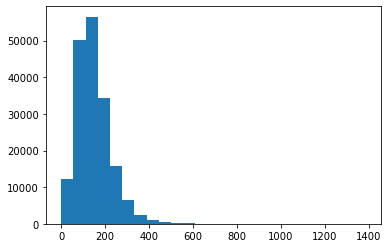

In [28]:
# Check the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=25);

In [29]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [30]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [61]:
# Create a char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2  # Add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    #  standardize=None, Set to None if you want to leave punctuation in
                                    name="char_vectorizer")

In [62]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [65]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Character Vectorizer Vocab Length: {len(char_vocab)}")
print(f"5 Most Common Character Instances: {char_vocab[:7]}")  # We index to seven because the first 2 are going to be '' and [UNK]
print(f"5 Least Commong Character Instances: {char_vocab[-5:]}")

Character Vectorizer Vocab Length: 28
5 Most Common Character Instances: ['', '[UNK]', 'e', 't', 'i', 'a', 'n']
5 Least Commong Character Instances: ['k', 'x', 'z', 'q', 'j']


In [67]:
# Test out character vectorizer
import random
random_train_char = random.choice(train_chars)
print(f"Charified text:\n{random_train_char}")
print(f"\nLength of random_train_char: {len(random_train_char)}")
vectorized_chars = char_vectorizer([random_train_char])
print(f"\nVectorized Chars:\n{vectorized_chars}")
print(f"\nLength of Vectorized Chars: {len(vectorized_chars[0])}")

Charified text:
s e v e n t y - t w o   c h i l d r e n   o f   a m e r i c a n   s o c i e t y   o f   a n e s t h e s i o l o g y   c l a s s i f i c a t i o n   (   a s a   )   p h y s i c a l   s t a t u s   (   i   &   i i   )   ,   a g e d   @ - @   y e a r s   ,   w e r e   r a n d o m l y   a s s i g n e d   t o   o n e   o f   t w o   e q u a l   g r o u p s   .

Length of random_train_char: 357

Vectorized Chars:
[[ 9  2 21  2  6  3 19  3 20  7 11 13  4 12 10  8  2  6  7 17  5 15  2  8
   4 11  5  6  9  7 11  4  2  3 19  7 17  5  6  2  9  3 13  2  9  4  7 12
   7 18 19 11 12  5  9  9  4 17  4 11  5  3  4  7  6  5  9  5 14 13 19  9
   4 11  5 12  9  3  5  3 16  9  4  4  4  5 18  2 10 19  2  5  8  9 20  2
   8  2  8  5  6 10  7 15 12 19  5  9  9  4 18  6  2 10  3  7  7  6  2  7
  17  3 20  7  2 26 16  5 12 18  8  7 16 14  9  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Creating a Character-Level Embedding

In [68]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # input vocabulary for embedding layer
                              output_dim=25,  # Size used in original paper for joint-sequence modeling
                              mask_zero=True,
                              name="char_embed")


In [71]:
random_train_char = random.choice(train_chars)
print(f"Charified text:\n{random_train_char}")
print(f"\nLength of random_train_char: {len(random_train_char)}")
vectorized_chars = char_vectorizer([random_train_char])
print(f"\nVectorized Chars:\n{vectorized_chars}")
print(f"\nLength of Vectorized Chars: {len(vectorized_chars[0])}")
embedded_chars = char_embed(vectorized_chars)
print(f"\Embedded Chars:\n{embedded_chars}")
print(f"\nLength of Embedded Chars: {len(embedded_chars[0])}")
print(f"\nLength of Single Embedded Char: {len(embedded_chars[0][0])}") 


Charified text:
g r o u p   a   (   n   =   @   )   c o m p l e t e d   t h e   e y e s i   c a t a r a c t   s i m u l a t o r   t r a i n i n g   p r o g r a m m e   o n c e   a   w e e k   f o r   @   w e e k s   ,   w h i l e   g r o u p   b   (   n   =   @   )   c o m p l e t e d   i t   o n c e   a   w e e k   a t   t h e   f i r s t   a n d   t h e   l a s t   w e e k   .

Length of random_train_char: 365

Vectorized Chars:
[[18  8  7 16 14  5  6 11  7 15 14 12  2  3  2 10  3 13  2  2 19  2  9  4
  11  5  3  5  8  5 11  3  9  4 15 16 12  5  3  7  8  3  8  5  4  6  4  6
  18 14  8  7 18  8  5 15 15  2  7  6 11  2  5 20  2  2 23 17  7  8 20  2
   2 23  9 20 13  4 12  2 18  8  7 16 14 22  6 11  7 15 14 12  2  3  2 10
   4  3  7  6 11  2  5 20  2  2 23  5  3  3 13  2 17  4  8  9  3  5  6 10
   3 13  2 12  5  9  3 20  2  2 23  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Building and Training a Conv1D Model with Character-Level Embeddings

In [72]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs, 
                         outputs=outputs,
                         name="model_3_conv_1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [73]:
# Summary
model_3.summary()

Model: "model_3_conv_1d_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________

In [74]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [76]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_3_conv_1d_char_embeddings')]
                             )

Saving TensorBoard log files to: model_logs/model_3_conv_1d_char_embeddings/20210724-231518
Epoch 1/3
562/562 [==============================] - 7s 11ms/step - loss: 1.3847 - accuracy: 0.4263 - val_loss: 1.0356 - val_accuracy: 0.5934
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 1.0301 - accuracy: 0.5872 - val_loss: 0.9325 - val_accuracy: 0.6280
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.9346 - accuracy: 0.6390 - val_loss: 0.8631 - val_accuracy: 0.6606


In [77]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.2143403 , 0.23579265, 0.11671546, 0.40024292, 0.03290881],
       [0.2714889 , 0.1801421 , 0.00842878, 0.53058124, 0.00935893],
       [0.31451324, 0.1155061 , 0.05250896, 0.5069298 , 0.01054196],
       ...,
       [0.03004458, 0.0473036 , 0.23249196, 0.05057079, 0.639589  ],
       [0.02565262, 0.05423739, 0.3961361 , 0.04322953, 0.48074445],
       [0.39600533, 0.25255975, 0.25279272, 0.07443752, 0.0242046 ]],
      dtype=float32)

In [78]:
# Convert pred probs to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 3, 3, ..., 4, 4, 0])>

In [79]:
# Calculate results for Model 3
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.50046339202966,
 'precision': 0.6530527226948493,
 'recall': 0.6550046339202966,
 'f1': 0.646275346429274}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a modification)
3. Compile 1 and 2 with a concatenate layer (`layers.Concatenate`)
4. Build a Series of output layers on top of 3 similar to Figure 1 and section 4.2 of arXiv:1612.05251
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [105]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [106]:
# Get a summary
model_4.summary(line_length=125)

Model: "model_4_token_and_char_embeddings"
_____________________________________________________________________________________________________________________________
Layer (type)                             Output Shape               Param #        Connected to                              
char_input (InputLayer)                  [(None, 1)]                0                                                        
_____________________________________________________________________________________________________________________________
token_input (InputLayer)                 [(None,)]                  0                                                        
_____________________________________________________________________________________________________________________________
char_vectorizer (TextVectorization)      (None, 290)                0              char_input[0][0]                          
___________________________________________________________________________

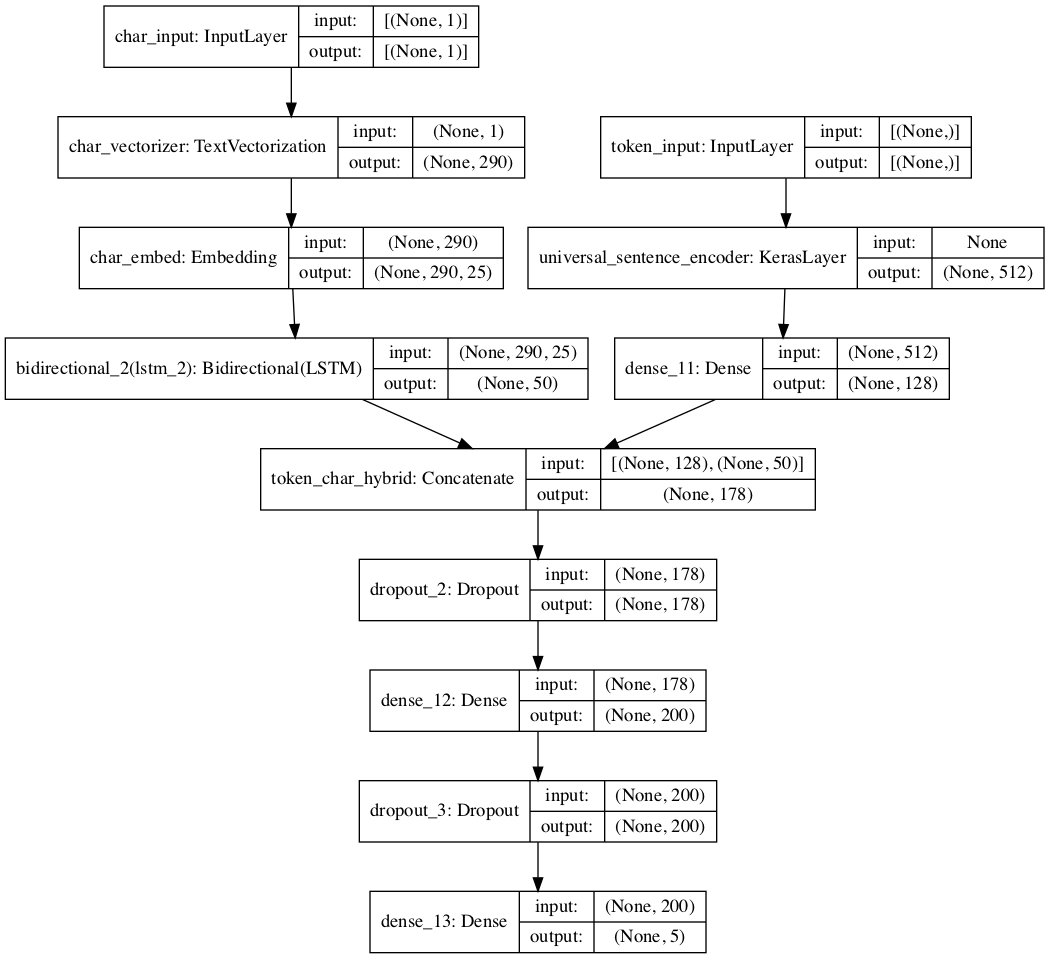

In [107]:
# Plot hybrid token and character model (Very Big Boi And KOOOOOOL)
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True, to_file="model_4_hybrid_char_token_model.png")

In [108]:
# Compile token char hybrid model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),  # Section 4.2 says to use SGD, jokes on them, were using Adam
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [109]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Make data (tokens first because that is the order the model was constructed in)
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # Cobine labels and data

# Prefetch and Batch data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [110]:
# Repeat the above steps for our validation data

# Combine chars and tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # Make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # Cobine labels and data

# Prefetch and Batch data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [111]:
# Check our train training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting a model on token and character-level sequences

In [112]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_token_char_hybrid")])

Saving TensorBoard log files to: model_logs/model_4_token_char_hybrid/20210725-003818
Epoch 1/3
562/562 [==============================] - 163s 279ms/step - loss: 1.1411 - accuracy: 0.5279 - val_loss: 0.7797 - val_accuracy: 0.6998
Epoch 2/3
562/562 [==============================] - 165s 294ms/step - loss: 0.8023 - accuracy: 0.6892 - val_loss: 0.7124 - val_accuracy: 0.7267
Epoch 3/3
562/562 [==============================] - 159s 283ms/step - loss: 0.7664 - accuracy: 0.7051 - val_loss: 0.6819 - val_accuracy: 0.7417


In [113]:
# Evaulate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 56s 59ms/step - loss: 0.6893 - accuracy: 0.7374


[0.689277172088623, 0.7374222278594971]

In [119]:
# Make predctions using the token-char embedding hybrid model (wow thats a long name)
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.8591426e-01, 2.8146067e-01, 5.7288990e-03, 2.1838862e-01,
        8.5076382e-03],
       [3.6771017e-01, 4.1310641e-01, 4.1960906e-03, 2.1283060e-01,
        2.1567759e-03],
       [3.1467962e-01, 1.4758384e-01, 7.1828894e-02, 4.2533487e-01,
        4.0572841e-02],
       ...,
       [4.1696109e-04, 7.6722084e-03, 7.2966859e-02, 2.5316852e-04,
        9.1869080e-01],
       [9.0968106e-03, 6.0462978e-02, 3.0358613e-01, 5.2114734e-03,
        6.2164265e-01],
       [3.7610459e-01, 3.5422045e-01, 1.9133735e-01, 4.1079324e-02,
        3.7258245e-02]], dtype=float32)

In [122]:
# Get class labels for predictions
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:20]

<tf.Tensor: shape=(20,), dtype=int64, numpy=array([0, 1, 3, 2, 2, 2, 2, 2, 4, 1, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1])>

In [124]:
# Get model 4 results
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

{'accuracy': 73.74222163378789,
 'precision': 0.736954640852392,
 'recall': 0.737422216337879,
 'f1': 0.7354402353339939}

## Model 5: Transfer Learning with Pretrained Token Embeddings + Character Embeddings + Positional Embeddings

In [125]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note** 🔑  : Any engineered features used to train a model need to be available at test time. In our case, total lines and line numbers are readily available

### Create Positional Embeddings

In [32]:
# How many different line numbers are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

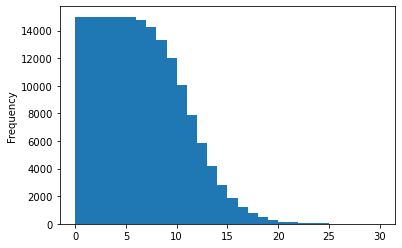

In [33]:
# Check the distribution of 'line_number' column
train_df.line_number.plot.hist(bins=30)

In [34]:
# Use TensorFlow to create one-hot encoded tensors of our 'line_number' column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], val_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([30212, 15]))

Now we've encoded our `line_numbers` feature, let's do the same for our total lines feature

In [35]:
# How many different total lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

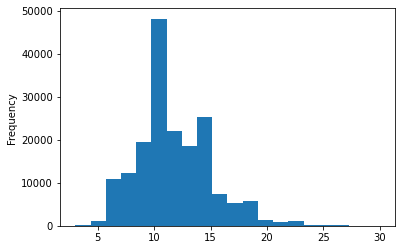

In [36]:
# Check the distributions of total lines
train_df.total_lines.plot.hist(bins=20);

In [37]:
# Check to coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [38]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([30212, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model 

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Pass the outputs of 5 into a `tf.keras.layers.Dropout` layer
7. Combine the outputs of 3,4, & 5 using `tf.keras.layers.Concatenate`
8. Create an output layers to accept the tribrid embedding and output label probabilities
9. Combine the inputs of 1,2,3 & 4 and the outputs of 7 into a `tf.keras.Model`

In [144]:
# 1. Token-level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_level_model")

# 2. Character-level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, activation="tanh"))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm,
                            name="char_level_model")

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
# Positional Embedding
# Dense is technically an embdding layer for one-hot data
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,
                                   line_number_outputs,
                                   name="line_number_model")

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_model")
# Positional Embedding
# Dense is technically an embdding layer for one-hot data (as in step 3)
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,
                                   total_lines_outputs,
                                   name="total_lines_model")

# 5. Concatenate Token and Char Embeddings in to a Hybrid Embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
# 6. Pass combined outputs into a Dropout layer
combined_dense = layers.Dense(256, activation="relu")(combined_embeddings)
combined_dropout = layers.Dropout(0.5)(combined_dense)

# 7. Concatenate the outputs of 3, 4, & 5 into a Tribrid Embedding (combine positional embddings with combined token and char embeddings)
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 combined_dropout])

# 8. Create output layer(s)
output_layer = layers.Dense(num_classes, activation="softmax")(tribrid_embeddings)

# 9. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_positional_char_token_model")

In [148]:
# Get a summary of our tribrid embedding model (Huge Boi...)
model_5.summary(150)

Model: "model_5_tribrid_positional_char_token_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
char_inputs (InputLayer)                         [(None, 1)]                      0                                                                   
______________________________________________________________________________________________________________________________________________________
token_inputs (InputLayer)                        [(None,)]                        0                                                                   
______________________________________________________________________________________________________________________________________________________
char_vectorizer (TextVectorization)      

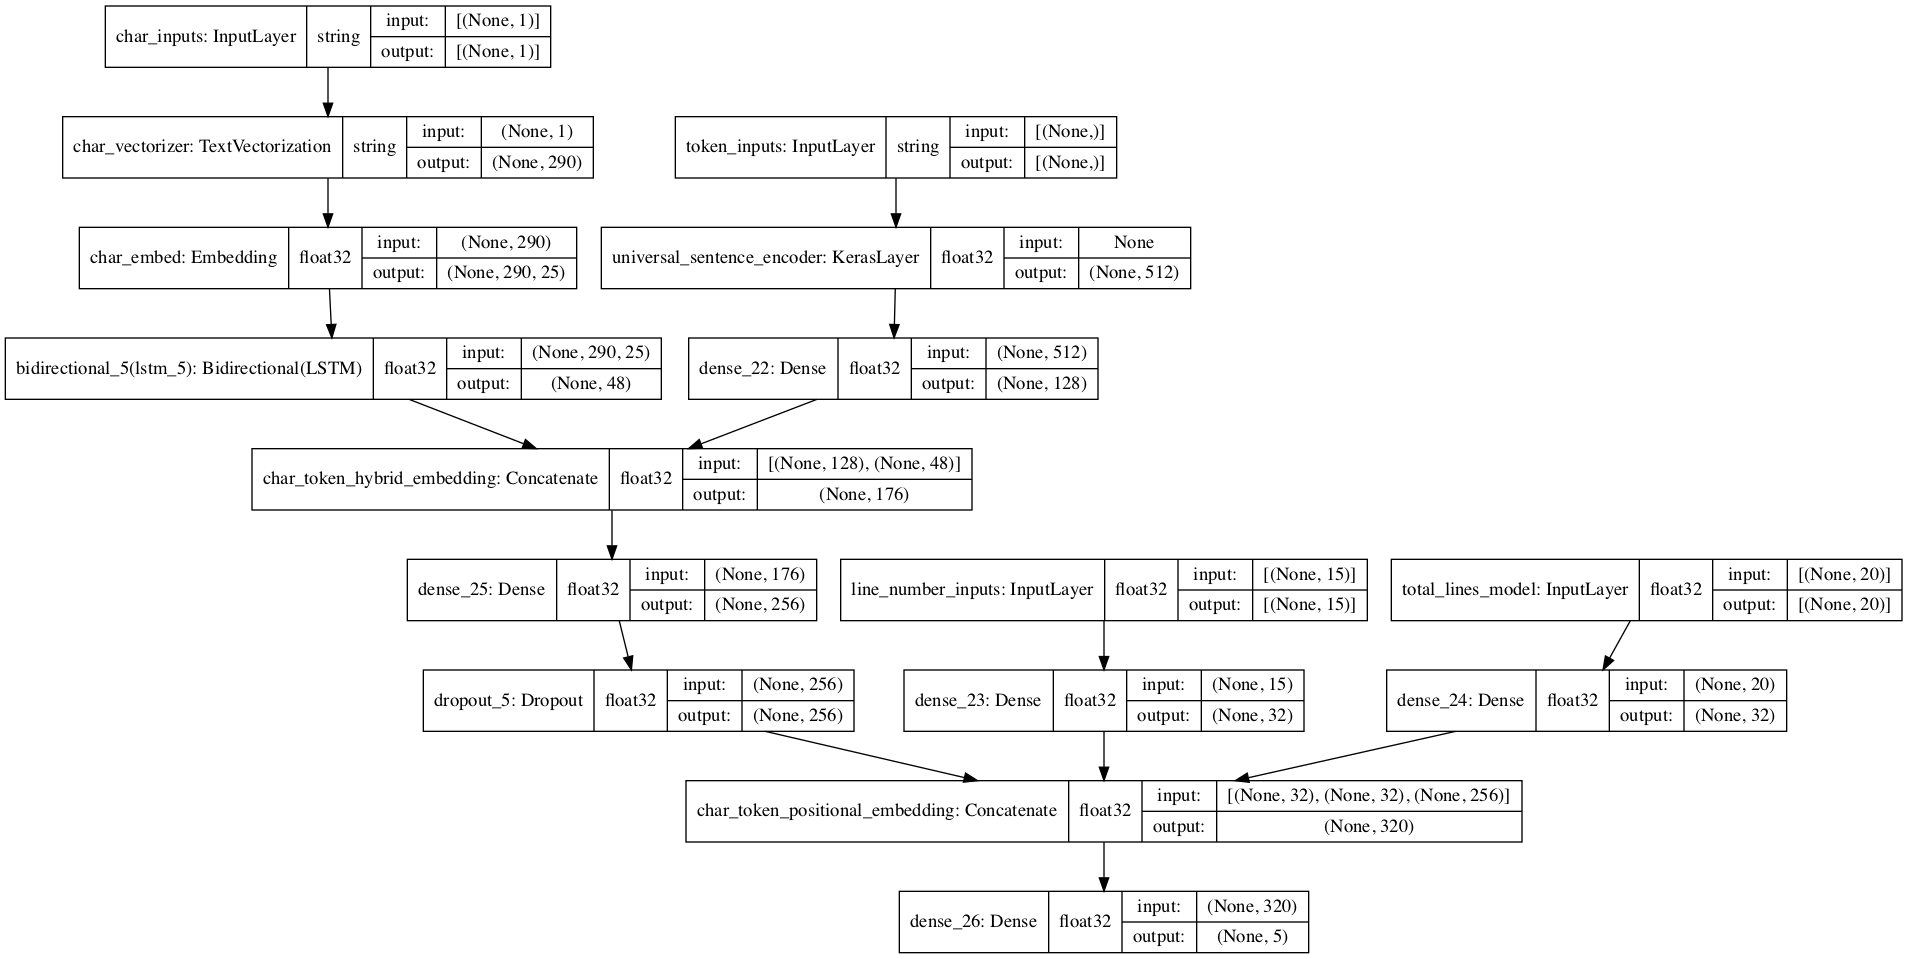

In [169]:
# Plot model_5 (tribrid embedding model) to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5, to_file="model_5_tribrid_embedding_model.png", show_shapes=True, show_dtype=True)

What is label smoothing?

for example if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider the other classes...

Really Confident: `[0.0, 0.0, 0.0, 1.0, 0.0]`

What label smoothing does is it assigns some of the value from the highes pred prob to other classes, in turn, hopefully imporving generalization: `[0.01, 0.01, 0.01, 0.96, 0.01]`

In [159]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # Helps to prevent Overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Creating tribrid embedding batch datasets using the tf.data API and prefetching them

In [39]:
# Creating Train Data and Train Label Datasets
train_char_token_pos_dataset = tf.data.Dataset.from_tensor_slices(((train_line_numbers_one_hot,
                                                                    train_total_lines_one_hot,
                                                                    train_sentences,
                                                                    train_chars),
                                                                   train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
# train_char_token_pos_dataset

# Validation dataset
val_char_token_pos_dataset = tf.data.Dataset.from_tensor_slices(((val_line_numbers_one_hot,
                                                                 val_total_lines_one_hot,
                                                                 val_sentences,
                                                                 val_chars),
                                                                val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
# val_char_token_pos_dataset


In [40]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

### Fitting, evaluating and making predictions with our tribrid model

In [187]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(train_char_token_pos_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_5_tribrid_positional_char_token_model")])

Saving TensorBoard log files to: model_logs/model_5_tribrid_positional_char_token_model/20210725-195220
Epoch 1/3
562/562 [==============================] - 176s 301ms/step - loss: 1.2327 - accuracy: 0.6180 - val_loss: 0.9786 - val_accuracy: 0.8009
Epoch 2/3
562/562 [==============================] - 167s 298ms/step - loss: 0.9746 - accuracy: 0.8117 - val_loss: 0.9494 - val_accuracy: 0.8238
Epoch 3/3
562/562 [==============================] - 158s 280ms/step - loss: 0.9551 - accuracy: 0.8188 - val_loss: 0.9340 - val_accuracy: 0.8357


In [188]:
# Make predictions with the tribrid embedding model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 43s 43ms/step


array([[0.48388538, 0.11321353, 0.01114777, 0.3723046 , 0.01944874],
       [0.53209907, 0.10425548, 0.04947226, 0.30279195, 0.01138124],
       [0.31163108, 0.10912769, 0.14945962, 0.3602665 , 0.06951503],
       ...,
       [0.0436054 , 0.12969284, 0.04455049, 0.03597573, 0.7461756 ],
       [0.03326529, 0.2833065 , 0.08324847, 0.03055165, 0.5696281 ],
       [0.23981766, 0.5368581 , 0.10164677, 0.04459232, 0.07708517]],
      dtype=float32)

In [189]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [191]:
# Calculate results
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.27816761551702,
 'precision': 0.8320501297364408,
 'recall': 0.8327816761551702,
 'f1': 0.8317088529369773}

## Compare model results

In [192]:
# Combine model results into a dataframe

all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_tf_hub_pretrained_sentence_encoder": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_char_token_hybrid_embedding": model_4_results,
                                  "model_5_char_token_pos_tribrid_embedding": model_5_results})
all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.700516,0.783341,0.787005,0.784178
model_2_tf_hub_pretrained_sentence_encoder,71.385542,0.714541,0.713855,0.710916
model_3_custom_char_embedding,65.500463,0.653053,0.655005,0.646275
model_4_char_token_hybrid_embedding,73.742222,0.736955,0.737422,0.735440
model_5_char_token_pos_tribrid_embedding,83.278168,0.832050,0.832782,0.831709


In [193]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

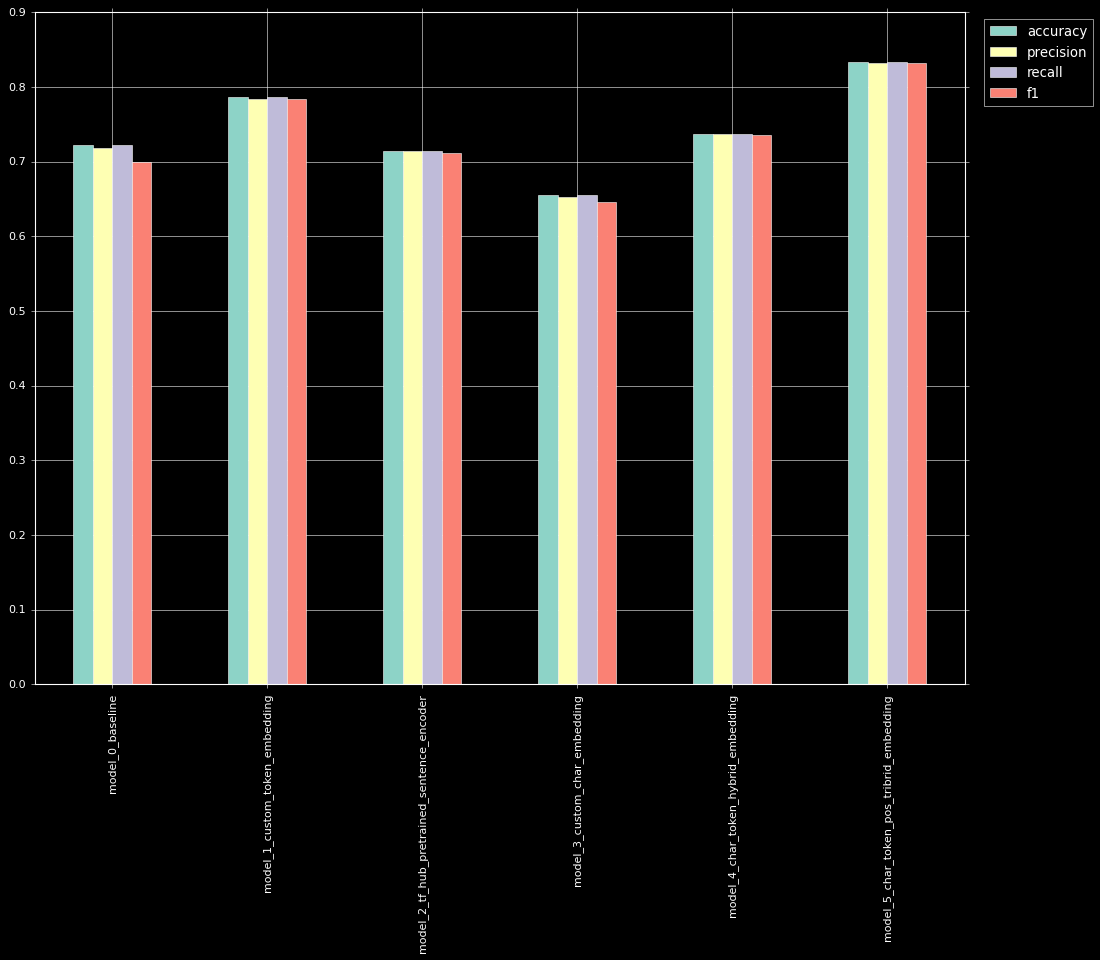

In [226]:
# Plot and compare all model results
import matplotlib.pyplot as plt
all_model_results.plot(kind="bar", figsize=(15, 10.5)).legend(bbox_to_anchor=(1.145, 1));

<AxesSubplot:>

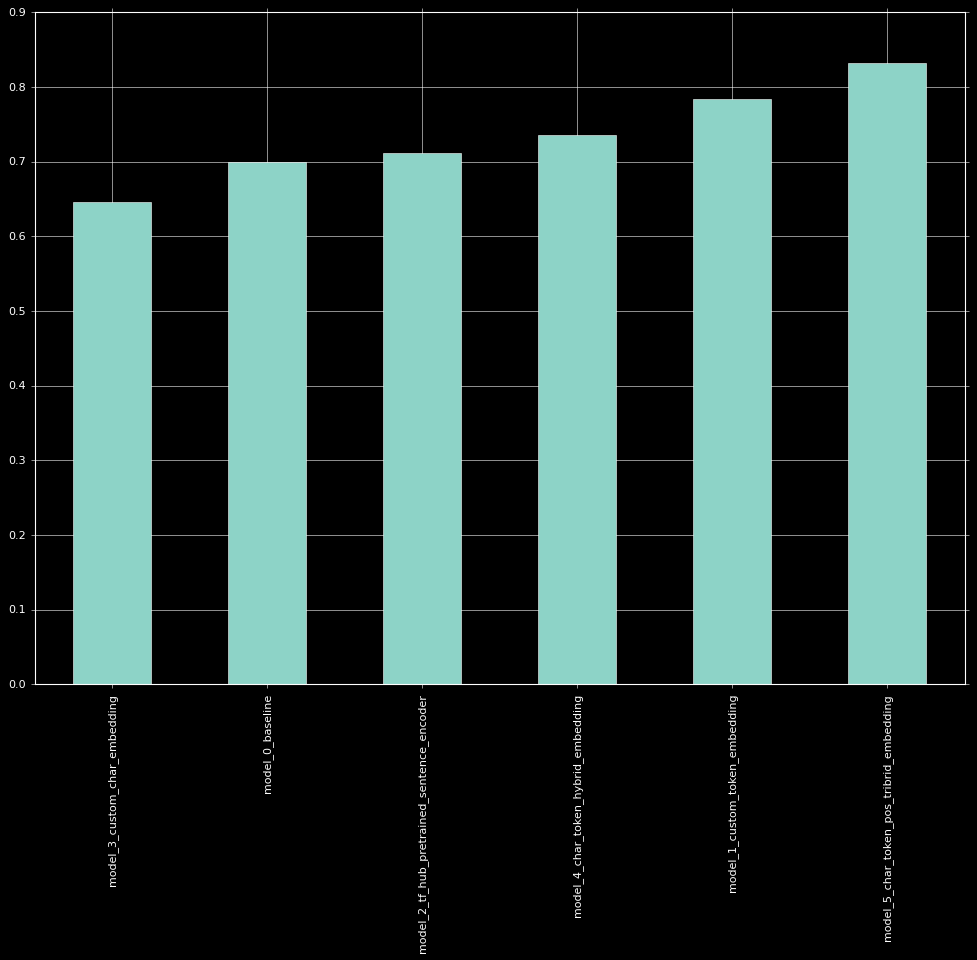

In [239]:
# Sort the model's results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(15, 10.5))

### Creating a Confusion Matrix ofr our best model's predictions

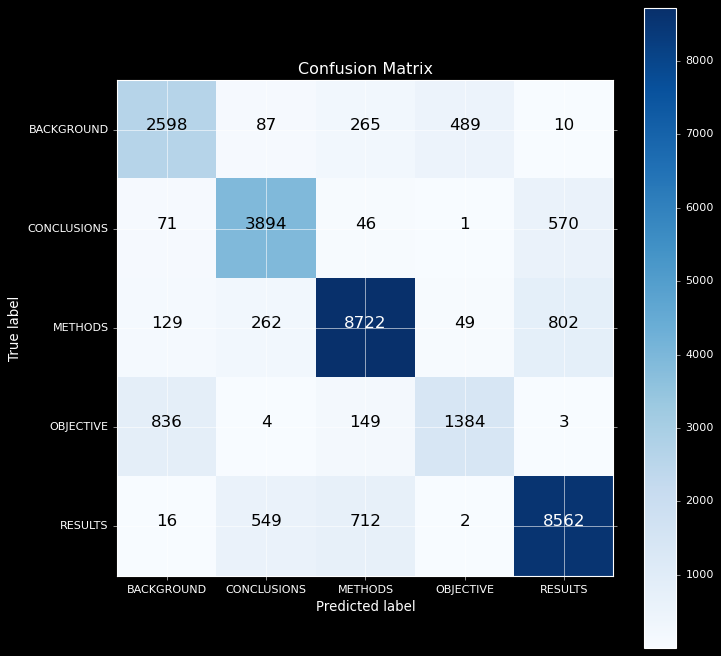

In [238]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(val_labels_encoded, model_5_preds, list(label_encoder.classes_))

## Saving and Loading our Best Model (Tribrid Model)

In [240]:
# Saving model_5 to SavedModel format
model_5.save(filepath="skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [241]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model", custom_objects=None) # For now

In [242]:
# Mae predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [245]:
# Calculate the results
loaded_model_results = calculate_results(val_labels_encoded, 
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.27816761551702,
 'precision': 0.8320501297364408,
 'recall': 0.8327816761551702,
 'f1': 0.8317088529369773}

In [246]:
assert model_5_results == loaded_model_results

In [252]:
# Check the loaded model summary
loaded_model.summary(150)

Model: "model_5_tribrid_positional_char_token_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
char_inputs (InputLayer)                         [(None, 1)]                      0                                                                   
______________________________________________________________________________________________________________________________________________________
token_inputs (InputLayer)                        [(None,)]                        0                                                                   
______________________________________________________________________________________________________________________________________________________
char_vectorizer (TextVectorization)      

## My Challenges

1. Turn the test data samples into a tf.data Dataset (fast loading) and then make predictions using the best performing model on the test samples
2. Find the most Wrong Predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).
3. Make example predictions (on RCT abstracts from the wild), I can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/
4. See the exercises and extra curriculum section on GitHub for more challenges

### Turn the test data samples into a tf.data Dataset (fast loading) and then make predictions using the best performing model on the test samples.

In [41]:
# Check to see our current test data
test_chars[:1], test_sentences[:1], test_df.columns, test_df.head()

(['t h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   a d h f   )   .'],
 ['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .'],
 Index(['target', 'text', 'line_number', 'total_lines'], dtype='object'),
        target                                               text  line_number  \
 0  BACKGROUND  this study analyzed liver function abnormaliti...            0   
 1     RESULTS  a post hoc analysis was conducted with the use...            1   
 2     RESULTS  liver function tests ( lfts ) were measured at...            2   
 3     RESULTS  survival analyses were used to assess the asso...            3   
 4     RESULTS  the percentage of patients with abnormal lfts ...            4   
 

Ok, we have a chars, sentences, and a dataframe. We also have test labels. Lets get this into a 4-input tf.data Dataset along with the labels

In [42]:
test_char_token_pos_dataset = tf.data.Dataset.from_tensor_slices(((test_line_numbers_one_hot,
                                                                   test_total_lines_one_hot,
                                                                   test_sentences,
                                                                   test_chars),
                                                                  (test_labels_one_hot))).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_pos_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

Ok, now that we have our tf.data Dataset let's make predictions and evaluate them!

In [43]:
# Make predictions
loaded_model_test_pred_probs = loaded_model.predict(test_char_token_pos_dataset)
loaded_model_test_preds = tf.argmax(loaded_model_test_pred_probs, axis=1)
loaded_model_test_preds

NameError: name 'loaded_model' is not defined

In [260]:
# Calculate results
loaded_model_test_results = calculate_results(test_labels_encoded, loaded_model_test_preds)
loaded_model_test_results

{'accuracy': 82.75427244068358,
 'precision': 0.8264982866174169,
 'recall': 0.8275427244068359,
 'f1': 0.8263971652373749}

Ok! Not Bad! Almost 83 percent accuracy and 82.5 percent F1 Score on the test data!

### Find the most Wrong Predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).

In [271]:
# Create a test results dataframe
test_preds_df = pd.DataFrame({"test_sentences":test_sentences,
                              "test_predictions":loaded_model_test_preds, 
                              "test_pred_prob": np.max(loaded_model_test_pred_probs, axis=1),
                              "test_labels": test_labels_encoded})
test_preds_df

,test_sentences,test_predictions,test_pred_prob,test_labels
0,this study analyzed liver function abnormaliti...,3,0.449628,0
1,a post hoc analysis was conducted with the use...,0,0.379061,4
2,liver function tests ( lfts ) were measured at...,2,0.733118,4
3,survival analyses were used to assess the asso...,2,0.633540,4
4,the percentage of patients with abnormal lfts ...,4,0.724208,4
...,...,...,...,...
30130,there was a statistically significant between-...,4,0.817713,4
30131,there were no statistically significant betwee...,4,0.748101,4
30132,there was no significant association between s...,4,0.671428,4
30133,no adverse effects were reported .,4,0.688092,4


In [272]:
# Check wether pred is correct or not
test_preds_df["correct_prediction"] = (test_preds_df["test_predictions"] == test_preds_df["test_labels"]).astype(int)

In [273]:
test_preds_df

,test_sentences,test_predictions,test_pred_prob,test_labels,correct_prediction
0,this study analyzed liver function abnormaliti...,3,0.449628,0,0
1,a post hoc analysis was conducted with the use...,0,0.379061,4,0
2,liver function tests ( lfts ) were measured at...,2,0.733118,4,0
3,survival analyses were used to assess the asso...,2,0.633540,4,0
4,the percentage of patients with abnormal lfts ...,4,0.724208,4,1
...,...,...,...,...,...
30130,there was a statistically significant between-...,4,0.817713,4,1
30131,there were no statistically significant betwee...,4,0.748101,4,1
30132,there was no significant association between s...,4,0.671428,4,1
30133,no adverse effects were reported .,4,0.688092,4,1


In [277]:
# Make wrong preds df and sort by pred probs
wrong_preds_df = test_preds_df[test_preds_df["correct_prediction"] == 0]
wrong_preds_df = wrong_preds_df.sort_values("test_pred_prob", ascending=False)


In [276]:
wrong_preds_df

,test_sentences,test_predictions,test_pred_prob,test_labels,correct_prediction
8545,pretest-posttest .,0,0.944995,2,0
16347,to evaluate the effects of the lactic acid bac...,3,0.940389,0,0
13874,symptom outcomes will be assessed and estimate...,2,0.935268,1,0
1827,nct@ ( clinicaltrials.gov ) .,0,0.931592,1,0
28602,www.chictr.org registration chictr-trc-@ .,0,0.919371,1,0
...,...,...,...,...,...
24167,the vitamin d supplementation and cardiac auto...,1,0.246198,0,0
17522,we used data from a weight loss intervention t...,0,0.244046,2,0
19439,it also looks at whether ` feedback-informed t...,1,0.242286,0,0
23023,"our aims are to understand how , why , and for...",1,0.231741,0,0


Even though we have 95% confidence in a wrond prediction, this is very good. Usually there is a 99+% confidence in the most wrong prediction. It looks like label smoothing has worked

In [279]:
# Get class names
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [282]:
# Delete the correct_prediction column
del wrong_preds_df["correct_prediction"]
wrong_preds_df

,test_sentences,test_predictions,test_pred_prob,test_labels
8545,pretest-posttest .,0,0.944995,2
16347,to evaluate the effects of the lactic acid bac...,3,0.940389,0
13874,symptom outcomes will be assessed and estimate...,2,0.935268,1
1827,nct@ ( clinicaltrials.gov ) .,0,0.931592,1
28602,www.chictr.org registration chictr-trc-@ .,0,0.919371,1
...,...,...,...,...
24167,the vitamin d supplementation and cardiac auto...,1,0.246198,0
17522,we used data from a weight loss intervention t...,0,0.244046,2
19439,it also looks at whether ` feedback-informed t...,1,0.242286,0
23023,"our aims are to understand how , why , and for...",1,0.231741,0


In [305]:
# View Most Wrong Predictions
most_wrong = wrong_preds_df[:20]
for _, sentence, pred, pred_prob, label in most_wrong.itertuples():
    print(f"Test Sentence: {sentence}\n")
    print(f"Tribrid Model Prediction and Confidence:\n{class_names[pred]}: {pred_prob:.5f}")
    print(f"Correct Class: {class_names[label]}")
    print("="*100)

Test Sentence: pretest-posttest .

Tribrid Model Prediction and Confidence:
BACKGROUND: 0.94499
Correct Class: METHODS
Test Sentence: to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

Tribrid Model Prediction and Confidence:
OBJECTIVE: 0.94039
Correct Class: BACKGROUND
Test Sentence: symptom outcomes will be assessed and estimates of cost-effectiveness made .

Tribrid Model Prediction and Confidence:
METHODS: 0.93527
Correct Class: CONCLUSIONS
Test Sentence: nct@ ( clinicaltrials.gov ) .

Tribrid Model Prediction and Confidence:
BACKGROUND: 0.93159
Correct Class: CONCLUSIONS
Test Sentence: www.chictr.org registration chictr-trc-@ .

Tribrid Model Prediction and Confidence:
BACKGROUND: 0.91937
Correct Class: CONCLUSIONS
Test Sentence: clinicaltrials.gov identifier : nct@ .

Tribrid Model Prediction and Confidence:
BACKGROUND: 0.91732
Correct Class: CONCLUSIONS
Test Sentence: ( clinicaltrials.gov : nct@ ) .

Tribrid Model Prediction a

### Predicting on Abstracts from the wild

In [44]:
# Make a Preprocessing function for the abstract
def preprocess_and_predict_abstract(abstract:str,
                                    model,
                                    classes=['BACKGROUND',
                                             'CONCLUSIONS',
                                             'METHODS',
                                             'OBJECTIVE',
                                             'RESULTS'],
                                    correct_class_order=["BACKGROUND",
                                                         "OBJECTIVE",
                                                         "METHODS",
                                                         "RESULTS",
                                                         "CONCLUSIONS"]):
    """
    Preprocess a RCT abstract in pure string form
    """
    # Get lines
    abstract_lines = abstract.split(". ")
    # Get chars
    chars = np.array([" ".join(list(i)) for i in abstract_lines])
    # Get tokens
    sentences = np.array([i.strip() for i in abstract_lines])
    # Get line numbers
    line_numbers = np.array(list(range(len(abstract_lines))))
    line_numbers_one_hot = tf.one_hot(line_numbers, depth=15)
    # Get total lines
    total_lines = np.array([len(abstract_lines) - 1])
    total_lines_one_hot = [tf.one_hot(total_lines, depth=20) for i in range(len(abstract_lines))]
    total_lines_one_hot = tf.squeeze(total_lines_one_hot)
    # Create tf.data Dataset
    abstract_dataset = tf.data.Dataset.from_tensor_slices(((line_numbers_one_hot,
                                                           total_lines_one_hot,
                                                           sentences,
                                                           chars),
                                                          tf.ones([len(abstract_lines)]))).batch(len(abstract_lines))

    # Predict and get classes
    abstract_prediction_probs = model.predict(abstract_dataset)
    abstract_preds = tf.argmax(abstract_prediction_probs, axis=1)
    pred_classes = [classes[i] for i in abstract_preds]

    # Abstractify
    abstractified = []

    for pred, sentence in zip(pred_classes, abstract_lines):
        abstractified.append({pred: sentence})

    # Delete for next set of iterations
    del pred
    del sentence

    # Decompose "abstractify"
    decomposed = [[] for i in range(len(correct_class_order))]

    for dict_ in abstractified:
        for pred, sentence in dict_.items():
            for i in range(len(correct_class_order)):
                if pred == correct_class_order[i]:
                    decomposed[i].append(sentence)
    
    # Turn Decomposed data into Abstract Chunks
    
    for class_ in range(len(decomposed)):
        # Turn into abstract chunks and append the class and a period at the end
        decomposed[class_] = correct_class_order[class_] + ":  " + ". ".join(decomposed[class_]) + "."
    
    skimlitted_abstract = "\n".join(decomposed)
    return skimlitted_abstract

In [430]:
abstract_to_predict = """Currently, there is confusion about the value of using nutritional support to treat malnutrition and improve functional outcomes in chronic obstructive pulmonary disease (COPD). This systematic review and meta-analysis of randomized, controlled trials (RCT) aimed to clarify the effectiveness of nutritional support in improving functional outcomes in COPD. A systematic review identified 12 RCT (n = 448) in stable COPD patients investigating the effects of nutritional support (dietary advice (1 RCT), oral nutritional supplements (10 RCT), enteral tube feeding (1 RCT)) versus control on functional outcomes. Meta-analysis of the changes induced by intervention found that while respiratory function (forced expiratory volume in 1 s, lung capacity, blood gases) was unresponsive to nutritional support, both inspiratory and expiratory muscle strength (maximal inspiratory mouth pressure +3.86 standard error (SE) 1.89 cm H2 O, P = 0.041; maximal expiratory mouth pressure +11.85 SE 5.54 cm H2 O, P = 0.032) and handgrip strength (+1.35 SE 0.69 kg, P = 0.05) were significantly improved and associated with weight gains of ≥2 kg. Nutritional support produced significant improvements in quality of life in some trials, although meta-analysis was not possible. It also led to improved exercise performance and enhancement of exercise rehabilitation programmes. This systematic review and meta-analysis demonstrates that nutritional support in COPD results in significant improvements in a number of clinically relevant functional outcomes, complementing a previous review showing improvements in nutritional intake and weight."""
print(preprocess_and_predict_abstract(abstract_to_predict, loaded_model))

BACKGROUND:  Currently, there is confusion about the value of using nutritional support to treat malnutrition and improve functional outcomes in chronic obstructive pulmonary disease (COPD).
OBJECTIVE:  This systematic review and meta-analysis of randomized, controlled trials (RCT) aimed to clarify the effectiveness of nutritional support in improving functional outcomes in COPD.
METHODS:  A systematic review identified 12 RCT (n = 448) in stable COPD patients investigating the effects of nutritional support (dietary advice (1 RCT), oral nutritional supplements (10 RCT), enteral tube feeding (1 RCT)) versus control on functional outcomes.
RESULTS:  Meta-analysis of the changes induced by intervention found that while respiratory function (forced expiratory volume in 1 s, lung capacity, blood gases) was unresponsive to nutritional support, both inspiratory and expiratory muscle strength (maximal inspiratory mouth pressure +3.86 standard error (SE) 1.89 cm H2 O, P = 0.041; maximal expira

## Training a Tribrid Model with TensorFlow Hub Bert PubMed Expert

In [79]:
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
                                 trainable=False)
bert_embedding = hub.KerasLayer("https://tfhub.dev/google/experts/bert/pubmed/2",
                                trainable=False)


In [80]:
# Build a BERT Token-level, Char-Level, Positional Embedding Model
from tensorflow.keras import layers, Model
# 1. Token-level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
preprocessed_inputs = bert_preprocess(token_inputs) # Preprocess inputs for bert embedding
bert_embeddings = bert_embedding(preprocessed_inputs)
lstm_pooling = layers.LSTM(64)(bert_embeddings["sequence_output"])
token_outputs = layers.Dense(128, activation="relu")(lstm_pooling)
bert_token_model = tf.keras.Model(token_inputs, token_outputs, name="token_bert_level_model")

# 2. Character-level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, activation="tanh"))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm,
                            name="char_level_model")

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
# Positional Embedding
# Dense is technically an embdding layer for one-hot data
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,
                                   line_number_outputs,
                                   name="line_number_model")

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_model")
# Positional Embedding
# Dense is technically an embdding layer for one-hot data (as in step 3)
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,
                                   total_lines_outputs,
                                   name="total_lines_model")

# 5. Concatenate Token and Char Embeddings in to a Hybrid Embedding
combined_embeddings = layers.Concatenate(name="char_token_bert_hybrid_embedding")([bert_token_model.output,
                                                                                   char_model.output])
# 6. Pass combined outputs into a Dropout layer
combined_dense = layers.Dense(256, activation="relu")(combined_embeddings)
combined_dropout = layers.Dropout(0.5)(combined_dense)

# 7. Concatenate the outputs of 3, 4, & 5 into a Tribrid Embedding (combine positional embddings with combined token and char embeddings)
tribrid_embeddings = layers.Concatenate(name="char_token_bert_positional_embedding")([line_number_model.output,
                                                                                      total_lines_model.output,
                                                                                      combined_dropout])

# 8. Create output layer(s)
output_layer = layers.Dense(num_classes, activation="softmax")(tribrid_embeddings)

# 9. Put together model with all kinds of inputs
model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 bert_token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_6_tribrid_positional_char_token_bert_model")

In [81]:
# Model summary
model_6.summary()

Model: "model_6_tribrid_positional_char_token_bert_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      {'input_mask': (None 0           token_inputs[0][0]               
__________________________________________________________________________________________________
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      {'sequence_output':  109482241   keras_layer_2[0][0]              
                                                   

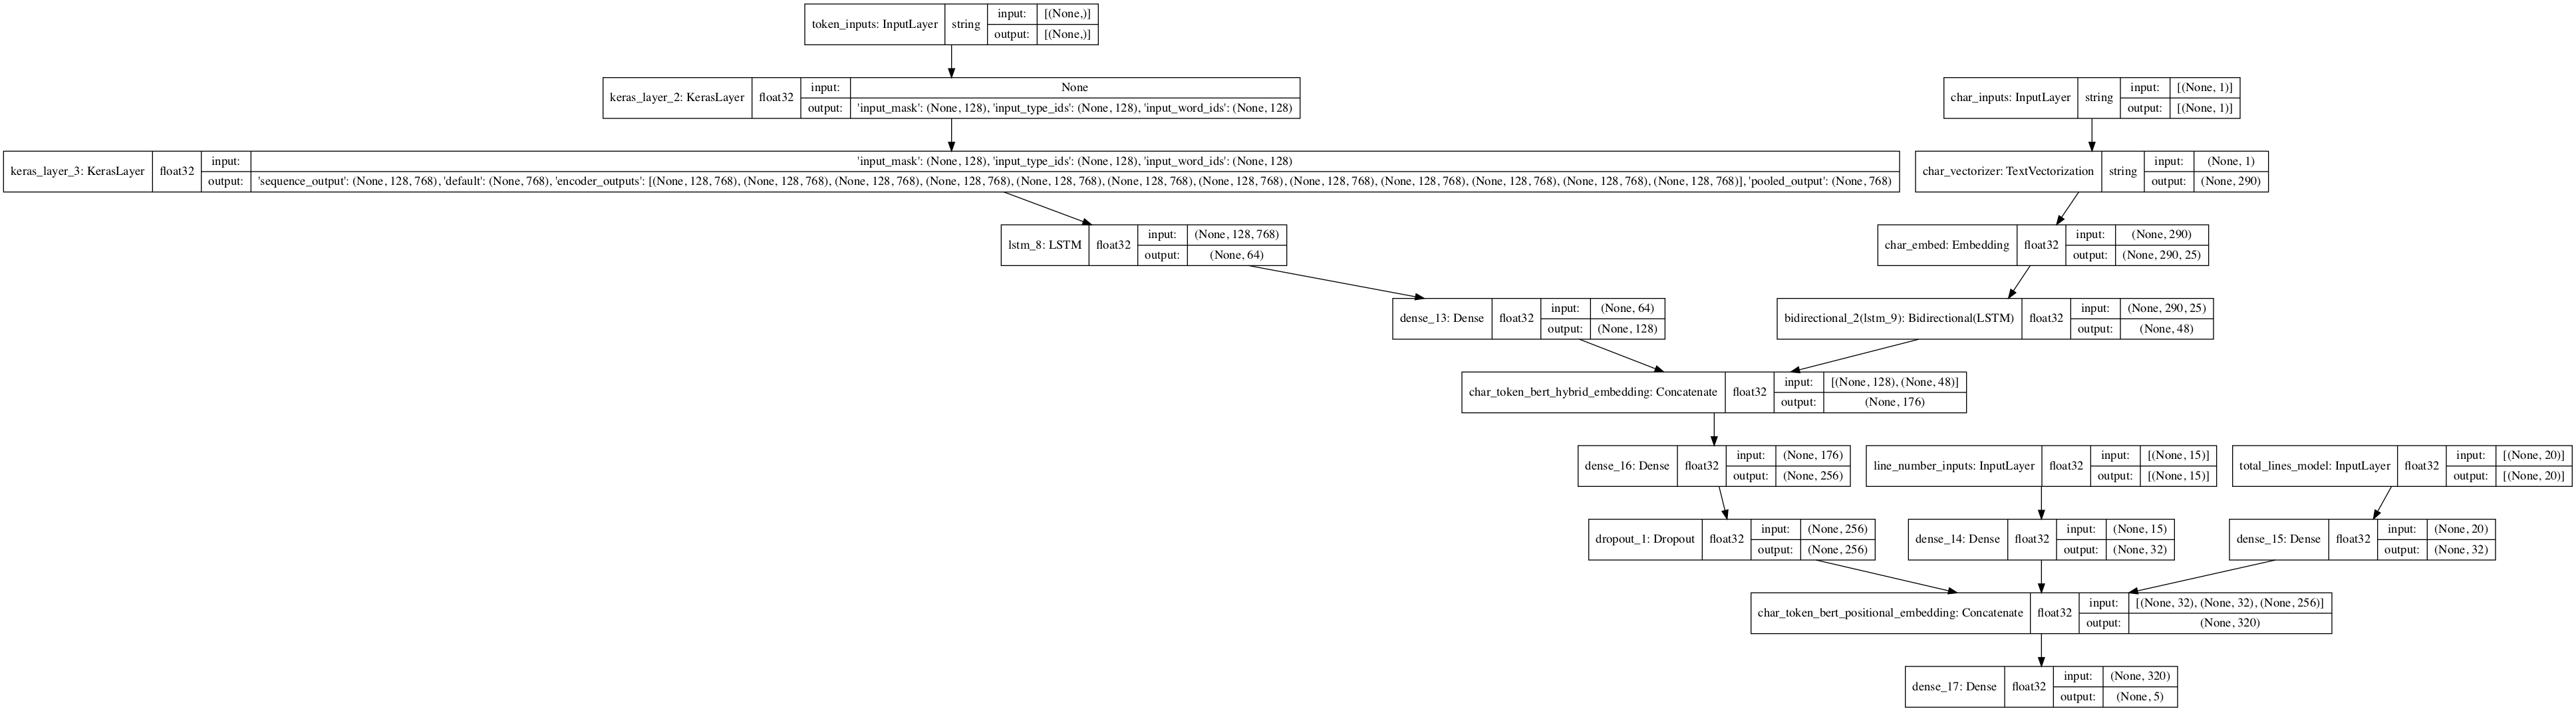

In [82]:
# Plot model (LOOONG)
from tensorflow.keras.utils import plot_model
plot_model(model_6, to_file="model_6_bert_tribrid_embedding.png", show_shapes=True, show_dtype=True)

In [83]:
# Compile model
# Use label smoothing
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



In [84]:
# Fit the model
# Fit our bert tribrid embedding model
history_model_6 = model_6.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(train_char_token_pos_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_6_bert_tribrid_positional_char_token_model")])

Saving TensorBoard log files to: model_logs/model_6_bert_tribrid_positional_char_token_model/20210726-182731
Epoch 1/3
562/562 [==============================] - 8676s 15s/step - loss: 0.9897 - accuracy: 0.7991 - val_loss: 0.8780 - val_accuracy: 0.8674
Epoch 2/3
562/562 [==============================] - 9305s 17s/step - loss: 0.8849 - accuracy: 0.8684 - val_loss: 0.8531 - val_accuracy: 0.8842
Epoch 3/3
562/562 [==============================] - 8434s 15s/step - loss: 0.8679 - accuracy: 0.8746 - val_loss: 0.8478 - val_accuracy: 0.8840


In [87]:
# Model Preds
model_6_pred_probs = model_6.predict(val_char_token_pos_dataset)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)


NameError: name 'calculate_results' is not defined

In [89]:
from helper_functions import calculate_results
model_6_results = calculate_results(val_labels_encoded, model_6_preds)

In [90]:
model_6_results

{'accuracy': 88.11399443929564,
 'precision': 0.8798799015233743,
 'recall': 0.8811399443929564,
 'f1': 0.8803700340299726}

#### Insane accuracy, but the speed-score tradeoff is not there.